# **STANDARD NOTEBOOK TO GET RESULTS**

## 1. Clean the Data

In [1]:
import pandas as pd 
import numpy as np 
# Jerome path : r'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DataBase.csv'
# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.dropna() # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

df_cleaned = df_cleaned.transpose() ## WE WANT COLUMNS TO BE VECTOR OF RETURN FOR A GIVEN TICKER

## 4. Get SP500 data for comparison

In [2]:
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier

def naive_portfolio(df_cleaned, timeframe):

    ## on calcule le rendement d'un portefeuille dans lequel chaque actif a un poids uniforme
    naive_portfolio_res = df_cleaned.mul(1/len(df_cleaned.columns)).sum(axis=1)[timeframe[0]:timeframe[1]]

    return naive_portfolio_res

def cumulative_returns(portfolio):

    # Compute cumulative returns
    cumulative_returns_res = (1 + portfolio).cumprod()

    return cumulative_returns_res

def plot_long_only(cumulative_returns, timeframe):

    # Multiply the cumulative returns by the initial investment
    initial_investment = 1
    portfolio_value = initial_investment * cumulative_returns

    # Generate date range
    start_date = timeframe[0]
    end_date = timeframe[1]
    dates = pd.date_range(start=start_date, end=end_date, periods=5279)

    # Plot the evolution of the portfolio value
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_value, color='blue', linestyle='-', linewidth=0.7, label='Portfolio Value')  # Adjust appearance here
    plt.title('Evolution of Long-Only Portfolio Strategy (2000-2020)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')

    # Customize x-axis ticks and labels
    plt.xticks(pd.date_range(start=start_date, end=end_date, freq='Y'), range(2000, 2021))

    plt.legend()
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enable grid with dashed lines
    plt.show()

    return 

def indicators(portfolio):
    
    # Assuming daily_returns is already defined as the daily returns of the portfolio

    # Calculate annualized returns
    annualized_return = np.prod(1 + portfolio) ** (252 / len(portfolio)) - 1  # Assuming 252 trading days in a year

    # Assuming a risk-free rate of 0 for simplicity
    risk_free_rate = 0

    # Calculate excess returns
    excess_returns = portfolio - risk_free_rate

    # Calculate the Sharpe ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)

    # Annualize the Sharpe ratio
    annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252)  # Assuming 252 trading days in a year

    print("Annualized Return:", annualized_return)
    print("Sharpe Ratio:", sharpe_ratio)
    print("Annualized Sharpe Ratio:", annualized_sharpe_ratio)

    return 

def noised_array(eta, lookback_window, evaluation_window, df_cleaned):

    if eta==0: ## si eta = 0, expected_return = moyenne des returns sur la période d'évaluation

            return df_cleaned.iloc[lookback_window[1]:lookback_window[1]+evaluation_window, :].mean(axis=0)
        
    else:
        # Extraction des rendements des actifs sur la période d'évaluation

        asset_returns = df_cleaned.iloc[lookback_window[1]:lookback_window[1]+evaluation_window, :]

        if eta==1:

            return df_cleaned.iloc[lookback_window[1]:lookback_window[1]+evaluation_window, :].mean(axis=1)
        
        else:
            # Calcul des moyennes et des écarts-types des rendements pour chaque actif
            asset_means = asset_returns.mean()
            asset_std_devs = asset_returns.std()

            # Initialisation du DataFrame pour stocker les rendements bruités
            noised_returns = asset_means.copy()

            # Itération sur chaque colonne (actif) pour ajouter du bruit
            for asset in asset_means.index:
                # Calcul de l'écart-type du bruit pour cet actif
                noise_std_dev = np.sqrt(asset_std_devs[asset]*2 / eta - asset_std_devs[asset]*2)

                # Génération du bruit
                noise = np.random.normal(0, noise_std_dev)

                # Ajout du bruit aux rendements de l'actif
                noised_returns[asset] = asset_means[asset] + noise
            y_max = noised_returns.max()
            y_min = noised_returns.min()
            x_max= asset_returns.max()
            x_min=asset_returns.min()
            # Mise à l'échelle de y pour qu'elle corresponde à l'échelle de x
            y_scaled = y_scaled = (noised_returns- y_min) * (x_max - x_min) / (y_max - y_min) + x_min
            # Mise à l'échelle de noised pour qu'elle corresponde à l'échelle des returns
            return y_scaled
            

def markowitz_weights(EWA_cov, lookback_window, df_cleaned, beta, eta, evaluation_window, short_selling):

    if EWA_cov:

        X = df_cleaned.iloc[lookback_window[0]:lookback_window[1], :].transpose()
        _, n_days = X.shape
        means = X.mean(axis=1)
        for i in range(len(means)):
            X.iloc[i, :] -= means[i]
        cov = ((1 - beta)/(1 - beta ** n_days)) * sum((beta**(n_days - 1 - t)*np.outer(X.iloc[:, t].values, X.iloc[:, t].values)) for t in range(n_days)).transpose()
        cov = pd.DataFrame(index=df_cleaned.columns, columns=df_cleaned.columns, data=cov)

    else:  
        cov = df_cleaned.iloc[lookback_window[0]:lookback_window[1], :].cov()

    cov = cov.fillna(0.)

    ## on construit le vecteur d'expected return du cluster (252 jours de trading par an, on passe de rendements journaliers à rendements annualisés)
            
    expected_returns = noised_array(eta, lookback_window, evaluation_window, df_cleaned)

    if short_selling: ## if we allow short-selling, then weights are not constrained to take nonnegative values, 
                            ## hence the (-1, 1) bounds
    
        ef = EfficientFrontier(expected_returns=expected_returns, cov_matrix=cov, weight_bounds=(-1, 1)) 
    
    else: 

        ef = EfficientFrontier(expected_returns=expected_returns, cov_matrix=cov, weight_bounds=(0, 1))

    ef.min_volatility()

    markowitz_weights = ef.clean_weights()

    return markowitz_weights

def portfolio_returns(df_cleaned, lookback_window, evaluation_window, EWA_cov, beta, eta, short_selling):

    m_weights = markowitz_weights(EWA_cov, lookback_window, df_cleaned, beta, eta, evaluation_window, short_selling)
    
    portfolio_returns = pd.DataFrame(index=df_cleaned.iloc[lookback_window[1]:lookback_window[1]+evaluation_window, :].index, columns=['return'], data=np.zeros(len(df_cleaned.iloc[lookback_window[1]:lookback_window[1]+evaluation_window, :].index)))

    for ticker in df_cleaned.columns: 

    ##  each time we add :            the present value of the return + the weighted "contribution" of the stock 'ticker' times is weight in the portfolio
        portfolio_returns['return'] = portfolio_returns['return'] + df_cleaned[ticker][lookback_window[1]:lookback_window[1]+evaluation_window]*m_weights[ticker]

    return portfolio_returns

def sliding_window(number_of_window, df_cleaned, lookback_window, evaluation_window, EWA_cov, beta, eta, short_selling):

    PnL = []
    daily_PnL = []
    overall_return = pd.DataFrame()
    portfolio_value=[1] #we start with a value of 1, the list contain : the porfolio value at the start of each evaluation period
    lookback_window_0 = lookback_window

    for i in range(1, number_of_window + 1):

        returns = portfolio_returns(df_cleaned, lookback_window_0, evaluation_window, EWA_cov, beta, eta, short_selling)

        overall_return = pd.concat([overall_return, returns])

        lookback_window_0 = [lookback_window[0] + evaluation_window*i, lookback_window[1] + evaluation_window*i]

        PnL = np.concatenate((PnL, np.reshape(np.cumprod(1 + returns)*1 - 1, (evaluation_window,))))## car on réinvestit immédiatement après
        daily_PnL = np.concatenate((daily_PnL, np.reshape(np.cumprod(1 + returns)*1 - 1, (evaluation_window,))))## car on réinvestit immédiatement après

        portfolio_value.append(portfolio_value[-1]+PnL[-1])

        print(f'step {i}/{number_of_window}, portfolio value: {portfolio_value[-1]:.4f}')

    n = len(PnL)//evaluation_window

    for j in range(1, n):

        for i in range(1, evaluation_window+1):
            
            PnL[j*evaluation_window + i - 1] = PnL[j*evaluation_window + i - 1] + PnL[j*evaluation_window - 1]
    
    return overall_return, PnL, portfolio_value, daily_PnL


In [3]:
######### year 2013-2019 ==> 3265:4774 --> on fera 4775 - 3265 pour un multiple de 2 --> 755 windows
lookback_window = [3190,3265] 
EWA_cov = False
beta = 0.90
evaluation_window = 5
short_selling = True
eta = 0.01
number_of_window = 352

m_weights_EWA = markowitz_weights(EWA_cov, lookback_window, df_cleaned, beta, eta, evaluation_window, short_selling)
weights = portfolio_returns(df_cleaned, lookback_window, evaluation_window, EWA_cov, beta, eta, short_selling)
overall_return, PnL, portfolio_value_markowitz, daily_PnL = sliding_window(number_of_window, df_cleaned, lookback_window, evaluation_window, EWA_cov, beta, eta, short_selling)

step 1/352, portfolio value: 1.0116
step 2/352, portfolio value: 1.0215
step 3/352, portfolio value: 1.0329
step 4/352, portfolio value: 1.0374
step 5/352, portfolio value: 1.0342
step 6/352, portfolio value: 1.0383
step 7/352, portfolio value: 1.0448
step 8/352, portfolio value: 1.0394
step 9/352, portfolio value: 1.0338
step 10/352, portfolio value: 1.0319
step 11/352, portfolio value: 1.0458
step 12/352, portfolio value: 1.0593
step 13/352, portfolio value: 1.0626
step 14/352, portfolio value: 1.0775
step 15/352, portfolio value: 1.0781
step 16/352, portfolio value: 1.0798
step 17/352, portfolio value: 1.0830
step 18/352, portfolio value: 1.0829
step 19/352, portfolio value: 1.0887
step 20/352, portfolio value: 1.0854
step 21/352, portfolio value: 1.0584
step 22/352, portfolio value: 1.0670
step 23/352, portfolio value: 1.0642
step 24/352, portfolio value: 1.0492
step 25/352, portfolio value: 1.0706
step 26/352, portfolio value: 1.0768
step 27/352, portfolio value: 1.0838
step 28/35

In [5]:
portfolio_value_m = cumulative_returns(overall_return)

df_PnL = 1 + pd.DataFrame(PnL, columns=['PnL'])

df_PnL

,PnL
0,1.008047
1,1.009193
2,1.013118
3,1.015446
4,1.011604
...,...
1755,1.421886
1756,1.423333
1757,1.423083
1758,1.421595


In [7]:
import process

## NAIVE: UNIFORM
timeframe = [3265, 5025]
naive_portfolio_res = naive_portfolio(df_cleaned, timeframe)
cum_returns = cumulative_returns(naive_portfolio_res)
initial_investment = 1
portfolio_value = initial_investment * cum_returns 

## NAIVE: MARKOWITZ
portfolio_value_m = cumulative_returns(overall_return)

## NAIVE: SP500
start_date = '2013-01-01'
end_date = '2019-12-31'
sp500_PnL = process.get_sp500_PnL(start_date, end_date)

# Generate the 1510 dates between the start and end dates
dates = pd.date_range(start=start_date, end=end_date, periods=1760)

# Interpolate the values from the original sp500_PnL vector
interpolated_sp500_PnL = np.interp(np.linspace(0, len(sp500_PnL) - 1, 1760), np.arange(len(sp500_PnL)), sp500_PnL)

portfolio_value_sp500 = cumulative_returns(interpolated_sp500_PnL)

[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.11/site-packages/yfinance/utils.py:781: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py:732: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sp500_data['Daily PnL'] = (sp500_data['Close'] - sp500_data['Open']) / sp500_data['Open'][0] ## /100 because we initially invest 1 dollar in our portfolio?


In [8]:
p_EWA = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_EWA.csv')
p_shortselling_EWA = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_shortselling_EWA.csv')
p_shortselling = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_shortselling.csv')
p_sp500 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_sp500.csv')
p_UNIFORM = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive_UNIFORM.csv')
p = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019/PnL_2013-2019_naive.csv')

### ETA = 0.01

## FOR 10 CLUSTERS
p_SPONGE_sym_SS_10 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/10 clusters/PnL_SPONGE_sym-Short-cov_75-5-0.01_clusters=10.csv')
p_SL_SS_10 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/10 clusters/PnL_signed_laplacian-Short-cov_75-5-0.01_clusters=10.csv')
p_SPONGE_SS_10 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/10 clusters/PnL_SPONGE-Short-cov_75-5-0.01_clusters=10.csv')
p_SPECTRAL_CLUSTERING_SS_10 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/10 clusters/PnL_Spectral-Short-cov_75-5-0.01_clusters=10.csv')

## FOR 17 CLUSTERS
p_SPONGE_sym_SS_17 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/17 clusters/PnL_Sponge_Sym-Short-cov_75-5-0.01.csv')
p_SL_SS_17 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/17 clusters/PnL_Signed_lap-Short-cov_75-5-0.01.csv')
p_SPONGE_SS_17 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/17 clusters/PnL_Sponge-Short-cov_75-5-0.01.csv')
p_SPECTRAL_CLUSTERING_SS_17 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/17 clusters/PnL_Spectral-Short-cov_75-5-0.01.csv')

## FOR 24 CLUSTERS
p_SPONGE_sym_SS_24 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/24 clusters/PnL_SPONGE_sym-Short-cov_75-5-0.01_clusters=24.csv')
p_SL_SS_24 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/24 clusters/PnL_signed_laplacian-Short-cov_75-5-0.01_clusters=24.csv')
p_SPONGE_SS_24 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/24 clusters/PnL_SPONGE-Short-cov_75-5-0.01_clusters=24.csv')
p_SPECTRAL_CLUSTERING_SS_24 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/24 clusters/PnL_spectral-Short-cov_75-5-0.01_cluster=24.csv')

## FOR 24 CLUSTERS WITH EWA
p_SPONGE_sym_SS_24_EWA = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/EWA/PnL_SPONGE_sym-short-cov_75-5-0.01_clusters=24_EWA.csv')
p_SL_SS_24_EWA = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/EWA/PnL_signed_laplacian-EWA0.99_24-5-0.01.csv')
p_SPONGE_SS_24_EWA = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/EWA/PnL_SPONGE-EWA0.99_24-5-0.01.csv')
p_SPECTRAL_CLUSTERING_SS_24_EWA = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/EWA/PnL_spectral-short-cov_75-5-0.01_cluster=24_EWA.csv')


## Without ETA
p_SL_SS_24_no_eta = 1 + pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_signed_laplacian-cov_24-5-0.csv')
p_Spectral_SS_24_no_eta = 1 + pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_spectral_clustering-cov_24-5-0.csv')
p_SPONGE_Sym_SS_24_no_eta = 1 + pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_24-5-0.csv')
p_SPONGE_SS_24_no_eta = 1 + pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE-cov_24-5-0.csv')


## VARYING ETA
p_SPONGE_sym_SS_10_01 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-0.1.csv')
p_SPONGE_sym_SS_10_001 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-0.01.csv')
p_SPONGE_sym_SS_10_05 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-0.5.csv')
p_SPONGE_sym_SS_10_09 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-0.9.csv')
p_SPONGE_sym_SS_10_1 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-1.csv')


/var/folders/q2/wg5gyfhj2r9cd97zfmckktvw0000gn/T/ipykernel_56160/3060840487.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.xticks(pd.date_range(start=start_date, end=end_date, freq='Y'), range(2014, 2021))
/var/folders/q2/wg5gyfhj2r9cd97zfmckktvw0000gn/T/ipykernel_56160/3060840487.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(f'+{portfolio_value[-1] - 1:.2f}%', (dates[-1], portfolio_value[-1]), xytext=(20, -20), textcoords='offset points', color='black', arrowprops=dict(arrowstyle="->", color='black'))


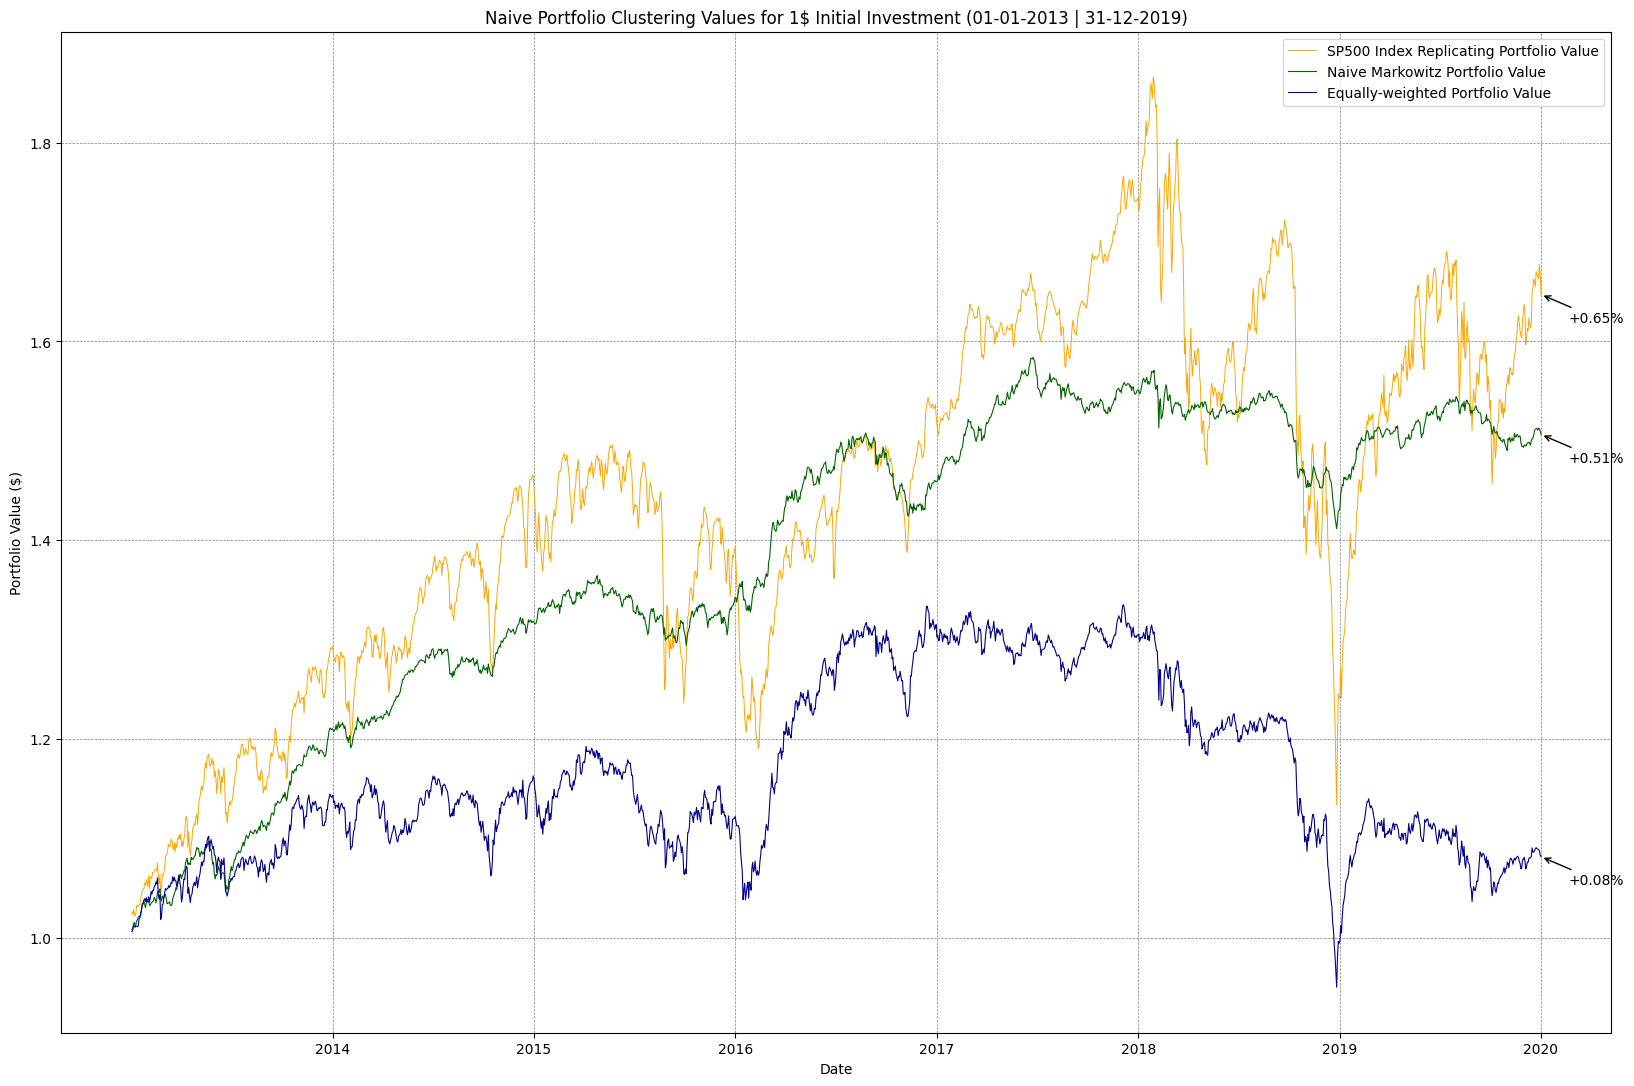

In [26]:
# Generate date range
start_date = '2013-01-01'
end_date = '2019-12-31'
dates = pd.date_range(start=start_date, end=end_date, periods=1760)

# Plot the evolution of the portfolio value
plt.figure(figsize=(20, 13))

# plt.plot(dates, portfolio_value_m, color='pink', linestyle='-', linewidth=0.7, label='Naive Markowitz Portfolio Value - No Eta')
'''plt.plot(dates, p_SPONGE_SS_24_EWA, color='#006400', linestyle='-', linewidth=0.5, label='SPONGE Value - EWA')   # Bleu clair
plt.plot(dates, p_SPECTRAL_CLUSTERING_SS_24_EWA, color='orange', linestyle='-', linewidth=0.5, label='Spectral Clustering Portfolio Value - EWA')
plt.plot(dates, p_SPONGE_sym_SS_24_EWA, color='#00008B', linestyle='-', linewidth=0.5, label='Symmetric SPONGE Portfolio Value - EWA')   # Bleu clair
plt.plot(dates, p_SL_SS_24_EWA, color='violet', linestyle='-', linewidth=0.5, label='Signed Laplacian Portfolio Value - EWA')   # Bleu clair
plt.plot(dates, portfolio_value_m, color='#FF0000', marker='s', markersize=1, linestyle='None', linewidth=0.5, label='Naive Markowitz Portfolio Value')   # Bleu clair
'''
'''plt.plot(dates, p_SPONGE_sym_SS_10_001, color='#006400', linestyle='-', linewidth=0.8, label='Symmetric SPONGE Portfolio Value - Eta = 0.01')   # Bleu clair
plt.plot(dates, p_SPONGE_sym_SS_10_01, color='orange', linestyle='-', linewidth=0.7, label='Symmetric SPONGE Portfolio Value - Eta = 0.1')
plt.plot(dates, p_SPONGE_sym_SS_10_05, color='#00008B', linestyle='-', linewidth=0.8, label='Symmetric SPONGE Portfolio Value - Eta = 0.5')   # Bleu clair
plt.plot(dates, p_SPONGE_sym_SS_10_09, color='#FF0000', linestyle='-', linewidth=0.8, label='Symmetric SPONGE Portfolio Value - Eta = 0.9')   # Bleu clair
plt.plot(dates, p_SPONGE_sym_SS_10_1, color='#00008B', linestyle='-', linewidth=0.8, label='Symmetric SPONGE Portfolio Value - Eta = 1.0')   # Bleu clair
'''
plt.plot(dates, portfolio_value_sp500, color='orange', linestyle='-', linewidth=0.7, label='SP500 Index Replicating Portfolio Value')   
plt.plot(dates, portfolio_value_m, color='#006400', linestyle='-', linewidth=0.8, label='Naive Markowitz Portfolio Value')   # Bleu clair
plt.plot(dates, portfolio_value, color='#00008B', linestyle='-', linewidth=0.8, label='Equally-weighted Portfolio Value')   # Bleu clair

'''plt.plot(dates, p_SPECTRAL_CLUSTERING_SS_24, color='#006400', linestyle='--', linewidth=0.5, label='Spectral Clustering Portfolio Value')  # Vert foncé
plt.plot(dates, p_SPONGE_SS_24, color='#FF0000', linestyle='--', linewidth=0.5, label='SPONGE Portfolio Value')  # Rouge vif
plt.plot(dates, p_SL_SS_24, color='#00008B', linestyle='--', linewidth=0.5, label='Signed Laplacian Portfolio Value')  # Bleu foncé
plt.plot(dates, p_SPONGE_sym_SS_24, color='orange', linestyle='--', linewidth=0.5, label='Symmetric SPONGE Portfolio Value')  # Violet
# plt.plot(dates, p_SPECTRAL_CLUSTERING_SS, color='blue', linestyle='-', linewidth=0.7, label='Spectral Clustering Portfolio Value')  '''

plt.title('Naive Portfolio Clustering Values for 1$ Initial Investment (01-01-2013 | 31-12-2019)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Customize x-axis ticks and labels
plt.xticks(pd.date_range(start=start_date, end=end_date, freq='Y'), range(2014, 2021))

## NAIVES STRAT ANNOTATIONS
'''plt.annotate(f'+{p_SL_SS_24_EWA["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SL_SS_24_EWA["PnL"].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{p_SPECTRAL_CLUSTERING_SS_24_EWA["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SPECTRAL_CLUSTERING_SS_24_EWA["PnL"].iloc[-1]), xytext=(20, 0), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{p_SPONGE_sym_SS_24_EWA["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SPONGE_sym_SS_24_EWA["PnL"].iloc[-1]), xytext=(20, 0), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{p_SPONGE_SS_24_EWA["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SPONGE_SS_24_EWA["PnL"].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))'''
plt.annotate(f'+{portfolio_value_m["return"].iloc[-1] - 1:.2f}%', (dates[-1], portfolio_value_m["return"].iloc[-1]), xytext=(20, -20), textcoords='offset points', color='black', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{portfolio_value[-1] - 1:.2f}%', (dates[-1], portfolio_value[-1]), xytext=(20, -20), textcoords='offset points', color='black', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{portfolio_value_sp500[-1] - 1:.2f}%', (dates[-1], portfolio_value_sp500[-1]), xytext=(20, -20), textcoords='offset points', color='black', arrowprops=dict(arrowstyle="->", color='black'))


'''plt.annotate(f'+{p_SL_SS_24["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SL_SS_24["PnL"].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{p_SPECTRAL_CLUSTERING_SS_24["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SPECTRAL_CLUSTERING_SS_24["PnL"].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{p_SPONGE_sym_SS_24["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SPONGE_sym_SS_24["PnL"].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{p_SPONGE_SS_24["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SPONGE_SS_24["PnL"].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))

'''
# CLUSTERING STRATS ANNOTATIONS
'''plt.annotate(f'+{portfolio_value_m["return"].iloc[-1] - 1:.2f}%', (dates[-1], portfolio_value_m['return'].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{portfolio_value[-1] - 1:.2f}%', (dates[-1], portfolio_value[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{p_SL_SS_10["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SL_SS_10["PnL"].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{p_SPONGE_SS_10["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SPONGE_SS_10["PnL"].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
plt.annotate(f'+{p_SPONGE_sym_SS_10["PnL"].iloc[-1] - 1:.2f}%', (dates[-1], p_SPONGE_sym_SS_10["PnL"].iloc[-1]), xytext=(20, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'))
'''
plt.legend()
plt.grid(True, which='both', axis='both', linestyle='--', color='grey', linewidth=0.5)  # Enable grid with dashed lines
plt.show()

In [68]:
p_SPONGE_sym_SS_10_01 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-0.1.csv')
p_SPONGE_sym_SS_10_001 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-0.01.csv')
p_SPONGE_sym_SS_10_05 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-0.5.csv')
p_SPONGE_sym_SS_10_09 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-0.9.csv')
p_SPONGE_sym_SS_10_1 = 1+pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/plot finaux/PnL_SPONGE_sym-cov_10-5-1.csv')

In [40]:
import numpy as np
import pandas as pd

def calculate_performance_metrics(PnL_Serie,duree_strat):
    """
    Calculate performance metrics for a series of end-of-day portfolio values.
    
    Parameters:
    PnL_Serie (pd.Series): Series of end-of-day values for the portfolio
    
    Returns:
    dict: Performance metrics including daily returns, volatility, total return, 
          annualized return, Sharpe ratio, and Sortino ratio.
    """
    
    # Ensure the input is a pandas Series
    if not isinstance(PnL_Serie, pd.Series):
        raise TypeError("The end-of-day values input must be a pandas Series.")
    
    # Calculate daily returns
    daily_returns = PnL_Serie.pct_change()
    
    # Calculate the daily mean return and daily volatility
    daily_mean_return = daily_returns.mean()
    daily_volatility = daily_returns.std()
    
    # Calculate total and annualized returns
    total_return = PnL_Serie.iloc[-1]  - 1
    annualized_return = (1 + total_return) ** (252 / duree_strat) - 1
    
    # Calculate annualized daily mean return and volatility
    annualized_daily_mean_return = daily_mean_return * 252
    annualized_volatility = daily_volatility * np.sqrt(252)
    
    # Sharpe ratio (using annualized figures)
    sharpe_ratio = annualized_return / annualized_volatility
    
    # Calculate Sortino ratio
    # First, get the negative returns only
    negative_returns = daily_returns[daily_returns < 0]
    annualized_downside_volatility = negative_returns.std() * np.sqrt(252)
    
    # Sortino ratio uses the same mean return as Sharpe but only the downside volatility
    sortino_ratio = annualized_return / annualized_downside_volatility
    
    # Compile results in a dictionary
    metrics = {
        'Daily Returns': daily_returns,
        'Volatility': daily_volatility,
        'Annualized Volatility': annualized_volatility,
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio
    }
    
    return metrics

calculate_performance_metrics(p_SPONGE_sym_SS_10_1.squeeze(),1760)

{'Daily Returns': 0            NaN
 1       0.003076
 2       0.004885
 3      -0.001917
 4       0.002507
           ...   
 1755    0.000836
 1756    0.000740
 1757    0.000202
 1758   -0.000229
 1759   -0.000304
 Name: PnL, Length: 1760, dtype: float64,
 'Volatility': 0.0014079933360532494,
 'Annualized Volatility': 0.02235120128899855,
 'Total Return': 2.054322553999521,
 'Annualized Return': 0.17335923795746422,
 'Sharpe Ratio': 7.756148571879808,
 'Sortino Ratio': 12.315923938558873}

In [10]:
## FOR 17 CLUSTERS
p_SPONGE_sym_SS_17 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/17 clusters/PnL_Sponge_Sym-Short-cov_75-5-0.01.csv')
p_SL_SS_17 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/17 clusters/PnL_Signed_lap-Short-cov_75-5-0.01.csv')
p_SPONGE_SS_17 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/17 clusters/PnL_Sponge-Short-cov_75-5-0.01.csv')
p_SPECTRAL_CLUSTERING_SS_17 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2019 jeje/17 clusters/PnL_Spectral-Short-cov_75-5-0.01.csv')


p_SPONGE_sym_SS_17['PnL'][0]

0.0069430349177381

In [27]:
def get_daily(cumulative_PnL):
    x_daily = np.zeros_like(cumulative_PnL)  # Initialiser le vecteur des PnL quotidiennes avec des zéros
    x_daily[0] = cumulative_PnL['PnL'][0]  # Assigner la valeur initiale à la première journée

    for i in range(1, len(cumulative_PnL)):
        x_daily[i] = (cumulative_PnL['PnL'][i] + 1) / np.cumprod(1 + x_daily[:i])[-1] - 1

    return pd.DataFrame(x_daily, columns=['PnL'])

daily_SPONGE_SS_17 = get_daily(p_SPONGE_SS_17)
daily_SPONGE_SS_17['PnL'].values

array([ 0.00888774,  0.00214132,  0.0038112 , ...,  0.00037348,
       -0.00109706, -0.00043524])

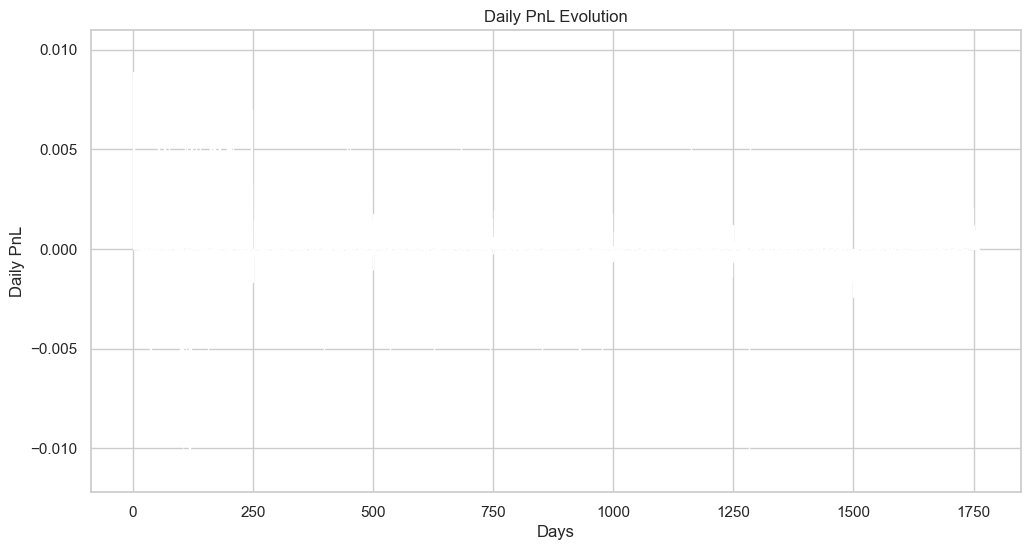

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(daily_SPONGE_SS_17['PnL'].values)+1), daily_SPONGE_SS_17['PnL'].values, color = 'red')

# Set labels and title
plt.xlabel('Days')
plt.ylabel('Daily PnL')
plt.title('Daily PnL Evolution')

# Show plot
plt.show()